# Regressão logística com Python

Para esta aula, estaremos trabalhando com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning!

Vamos tentar montar um algoritmo de classificação sobrevivente ou falecido utilizando regressão logística no Python.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
# stand to Machinelearning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Importando csv, aqui já esta sepraado para teste
train  = pd.read_csv('files/titanic_train.csv')

In [3]:
# vendo os dados
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# vendo os dados
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


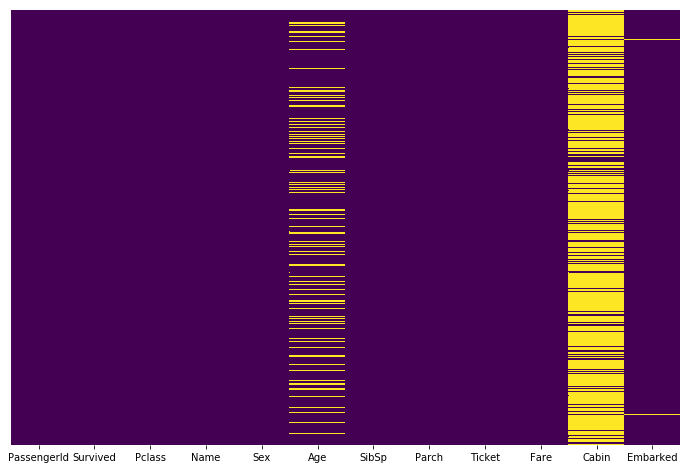

In [8]:
# Há dados que sao Nullos, podemos descobrir quais sao com DataFrame.isnull()
## Esse métodod retorna o DataFrame com True/Flase aonde é Nulo
plt.figure(figsize = (12,8)) # Aumentando tamnaho do plot
# @ytickylabels = nomes no eixo y
# @cbar = a presença ou nao da barra de cor, nao é necessario ja que é zero e um
sns.heatmap( train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Com o que foi mostado acima
+ Muitos nao tem cabine
+ um nao se sabe se te Embarked
+ Uma parte dos passagerios falta idade


In [9]:
# Definido estilos
sns.set_style('whitegrid')

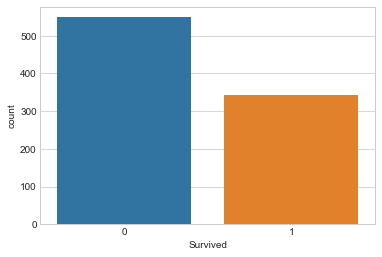

In [10]:
sns.countplot(x = 'Survived', data = train)
# Conclusão: Mais morreram do que sobreviveram

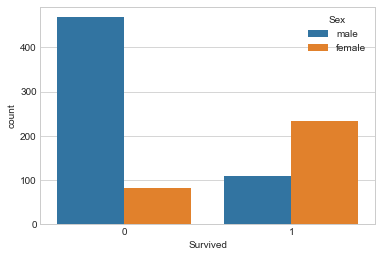

In [11]:
# Sexo é uma variavel categoricar (Srting), podemos  colocala no nosso grafico com @hue
sns.countplot(x = 'Survived', data = train, hue = 'Sex')
# Conclusao Abaixo: Mais homens morreram, e mulheres sobreviveram bem mais

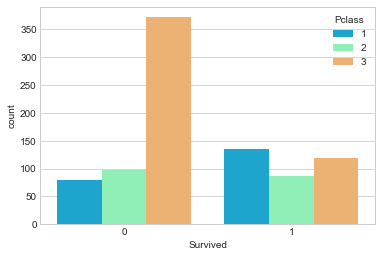

In [14]:
sns.countplot(x = 'Survived', data = train, hue = 'Pclass', palette = 'rainbow')
# moreram muita gente da classe 3, no resto é semelhante

In [40]:
# Contando quantidade de homesn e mulheres
train.groupby(['Sex']).count()
# Conclusao: há 577 homesn e 341 mulheres

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked
Sex,,,,,,,,,,
female,312,312,312,312,312,312,312,312,312,312
male,577,577,577,577,577,577,577,577,577,577


In [41]:
# Há outra forma melhor value_counts
train['Sex'].value_counts()

male      577
female    312
Name: Sex, dtype: int64

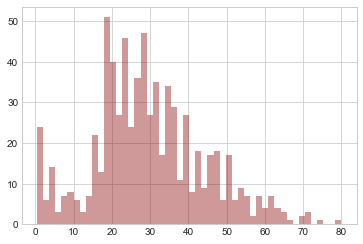

In [21]:
# Analisando a idade
# @bins = quanto maior, maior a presisao
# @alpha = float => tranparencia
train['Age'].hist(bins = 50, color = 'darkred', alpha = 0.4)
# Conclusao: maioria de 20 á 40 anos

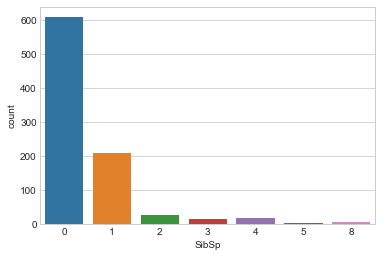

In [22]:
sns.countplot(x = 'SibSp', data = train)
# Conclusao: Maioria veio sozinho e umpouco veio com um acopanhate
# Semantica
## Maioria era solteiro e, ou, veio com acompanhate (1) (esposo esposa)
### Isso combina com a descriçao da idade, pois la era entre 20 a 40 anos


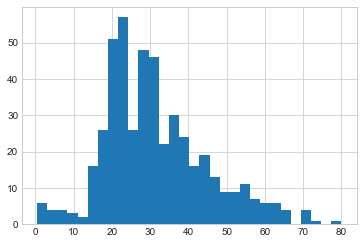

In [23]:
# Aqui, estamos pegando o histograma da idade das pessoas que estao sem acompanhante
train[ train['SibSp'] == 0]['Age'].hist(bins = 30)

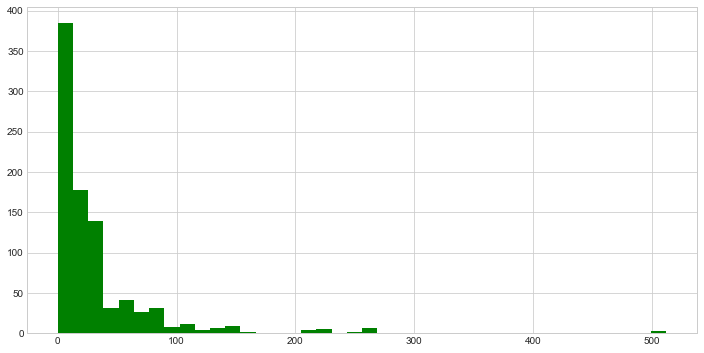

In [25]:
train['Fare'].hist(color = 'green', figsize = (12,6), bins = 40)
# Conclusao: a maioria esmagadora é de 0 a 100
# podemos entao dar um zoom, so pegar essa parte

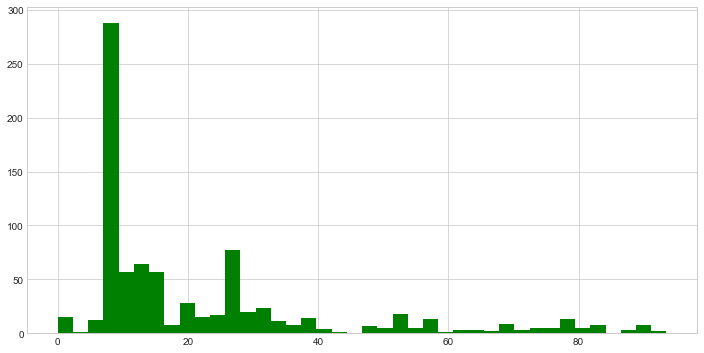

In [26]:
train[ train['Fare'] < 100]['Fare'].hist(color = 'green', figsize = (12,6), bins = 40)
# A grande maioria pagou entre 0 a 20 dolares

## Por que estamos fazendo tudo isso?
+ Para criar nosso modelos, temos que testar varias coisas, ver os dados de varios angulos e procurar as informaçoes que serao importatne para nos

___
## Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros.

+ Vamos tratar esses dados faltante para combinar com todo o modelo

---
### Corririgindo a idade

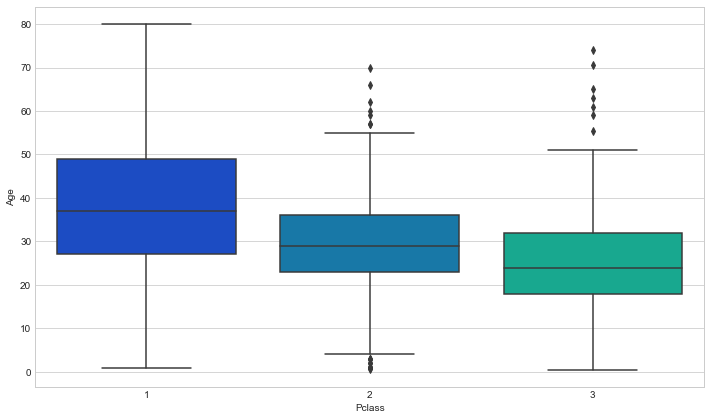

In [28]:
# Vamos criar ums estrategia  (com logica) para preencher com um bom chute as idades
plt.figure(figsize = (12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')
# Box plot é bom para analisar o intervalo de um dado, tipo, 
# qual a procetagem que esta acima da mediana (dado do meio) e quanto a baixo
# A linah enre as casisa é a mediana

# Conclusão: As classe mais altas sao de pessoas mais velhas

##### Estrategia: Vou preencher os dados com as medias das classes

In [6]:
# Vamos defnir essa funçao
# input_age = vamos passar 2 colunas : Age e Pclass
#    Analisamos, 
#        se ja tiver uma idade entao nao muda
#        se nao há idade
#             coloca o valor da média para a respectiva classe
#
def input_age(cols):
    print(str(type(cols)))
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [7]:
# Aplicando essa funçao nos nossoo dados
train['Age'] = train[ ['Age','Pclass'] ].apply(input_age, axis=1)
# Preenchmeos

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

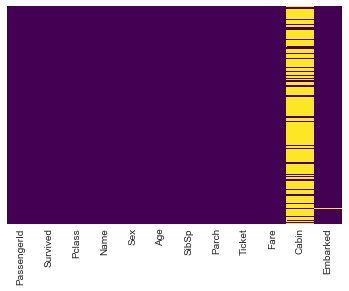

In [31]:
# Vmaos verificar mesmo
sns.heatmap( train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
# Como visto, Age agora ta toda preencida

---
### Corririgindo a Cabine
+ ==> Como há muitos dados faltantes, e , nao temos ideia do que preencher, entao vamos tirala fora

In [32]:
# deletando a coluna
train.drop('Cabin',axis=1,inplace=True)

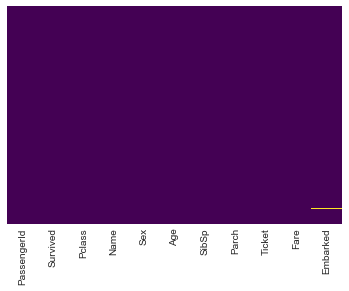

In [33]:
# verificando
sns.heatmap( train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

---
### Corririgindo o Passageiro que nao tem Embarked
+ ==> Como é somente uma única pessoa, para ter uma base de daods limpa, é melhor deleteramos ele

In [35]:
# DataFrame.dropna => deletea onde tem dado Null, o @inplace é pra aplicar em si
train.dropna(inplace=True)

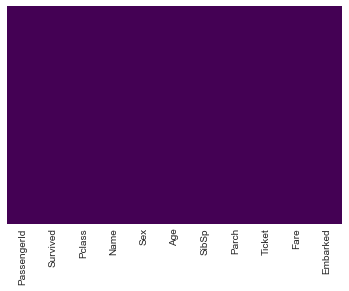

In [36]:
sns.heatmap( train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

---
### Corrigindo os dados categoricos (String)
+ A regressao logistica so trabalha com numeros, mas há strings

In [37]:
train.head() # Name, Sex, ticket e Embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [42]:
# Pandas.get_dummies() 
# Fz um group by, verifica os diferentes dados categorias e atribui um numero a eles
# Com isso agnt tranforma (male,female) ==> (0,1)
sex = pd.get_dummies(train['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinaridade
# o drop_first vai tirar uma coluna, mas ela se chamara male
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [43]:
# Favmos fazer o mesmo para embarked
#Contando os embarked
train['Embarked'].value_counts()
# COnclusa: temos 3 variaveis, da pra fazer o get_dummies

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [45]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


---
### Vamos excluir variaveis irrelevantes
+ Podemos tirar Nome, Sexo (pois ja temos um como numero)
+ O criterio para tirra é samentico e variavel ao problema

In [51]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)

ValueError: labels ['Sex' 'Embarked' 'Name' 'Ticket'] not contained in axis

In [52]:
# Deu esse erro pois nao da pra deletar duas vezes, pois as variaveis ficam na memoria
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [53]:
# Vou concatenar nas colunas, lado a lado
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Ótimo! Nossos dados estão prontos para o nosso modelo

# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

In [54]:
# Funçao para criar o modelo
from sklearn.linear_model import LogisticRegression

In [55]:
# Agora vmaos dividir nossos dados
from sklearn.model_selection import train_test_split

In [56]:
# Vai retornar 4 variaveis que ficaram nessa respectiva ordem
# Y sera o survived = So o Suviverd
# X os outros parametros mesno o 'Survived' por isso tem um drop nele
# @ test_size = 30% (vamos testar com 30 por cento)

# Para sabrer como ele faz, leia o livro
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [57]:
# Criamos a Classe da regressao logistica e rodamos
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train) # treinou com os dados de treino

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
# Ja temos o modelo, agora vamos ver as prediçoes dele no em X_Test
predictions = logmodel.predict(X_test)

## Testando se o modelo acertou ou nao
Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [59]:
# Essa classe serve para termos estatiscas para comparar acertos e erros
from sklearn.metrics import classification_report

In [60]:
# O sparam sao @1 = os addos certo,e @2 nossa prediçao
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.86       163
          1       0.85      0.65      0.74       104

avg / total       0.82      0.82      0.81       267



precisison = o mais imporatne significa que acerto 81% das mortes e 85% dos vivvos

### Matriz de Confusao

In [61]:
from sklearn.metrics import confusion_matrix

In [63]:
## Nossa matriz de confusao
print( confusion_matrix(y_test, predictions))

[[151  12]
 [ 36  68]]


---
DataScience é analise de dados, mas o preparao dos dados fica por conta do bom senso, talve, outras informaçaoes tambem poderia ser relevantes

OBS: Esse modelo acerto 80 sobre os dados de teste, mas e na relaidae, com os outros dados eles acertaria. (Sera que nao esta viciado de alguma forma)

Não foi tão ruim! Você pode querer explorar outros recursos no outro arquivo titanic_text.csv. Algumas sugestões:

* Tente pegar o título (Dr., Sr., Sra., Etc.) do nome como parâmetro.
* Talvez a cabine possa ser uma característica.
* Existe alguma informação que você pode obter do bilhete?

## END